## Program to generate the hologram of a phase-only SLM to compensate for its curvature and cavity spurious effects, as shown in  https://arxiv.org/pdf/2005.01561

##### 23 June 2020
##### authors: A. Pushkina, J. Costa-Filho, G. Maltese - University of Oxford

In [1]:
import numpy as np
import torch 

import cv2
import matplotlib.pyplot as plt

from scipy import interpolate

import sys, os
sys.path.append(os.path.join(os.getcwd(), 'lib'))
from beams import HgBasis

%matplotlib inline

In [2]:
ORDER = 1 # 1st diffraction order
axis_size = 500 # Number of points in the integration along theta
precision = 255 # Number of points in each axis of the inversion procedure
phi2_precision = 30 # Number of points in the discretization of the backplane curvature

def grid(period):
    """ Calculates a horizontal grating of a given period
    In:
        period - (int) grating period in pixel units
    Out:
        grating - (int matrix) blazing grating pattern in [0, 2pi)
    """
    t = np.arange(0,len(X_array),1) 
    slope = np.float64(1/period)
    wave = np.float64( np.mod(slope*t,1.0) ) 
    grating = np.empty( ( len(Y_array), len(X_array) ) )
    for i in range(resY):
        grating[i,:] = 2*np.pi*(wave)
    return grating

def shiftXY(mode,sx,sy):
    """ Shift a mode along x and y
    In:
        mode - (matrix) a mode to shift
        sx - shift along x
        sy - shift along y
    Out:
        o - (matrix) shifted mode
    """
    o = np.copy(mode)
    o = np.roll(o,sx,1)
    o = np.roll(o,sy,0)
    return o

def inverse_func(mode):
    """ Calculates M, F necesary to produce SLM hologram. 
    NOTE: depends on phi2, the SLM backplan curvature
    
    In:
        mode - (complex matrix) electric field to generate
    Out:
        output - (lst) M = output[0], F = output[1]

    """
    mode_abs = (255*np.abs(mode)).astype('uint8') 
    mode_angle = np.around(np.angle(mode)/np.pi).astype('uint') 

    index_phi2 = (phi2/(2*np.pi/phi2_precision)).astype('uint')    

    output = [None]*2
    output[0], output[1] = np.zeros((resY,resX)), np.zeros((resY,resX))

    for posx in range(resX):
        for posy in range(resY):
            output[0][posy,posx] = minimized_M[mode_abs[posy,posx],mode_angle[posy,posx],index_phi2[posy,posx]]
            output[1][posy,posx] = minimized_F[mode_abs[posy,posx],mode_angle[posy,posx],index_phi2[posy,posx]]
    return output

def cavity(mode, period):
    '''
    Returns the SLM hologram to produce an arbirary electric field in near-field 
    (Fig.2 paper), while compensating SLM's curvature and cavity spurious effects
    In:
        mode - (complex matrix) electric field to generate
        period - (int) SLM pattern blazing grating period  
    Out:
        psi - (real matrix) SLM pattern in [0, 2pi) scale
    '''
    M, F = inverse_func( np.abs(mode) * np.exp((1j)* np.angle(mode) ) )
    psi = M * np.mod( grid(period) + F, 2 * np.pi)
    return psi, M, F

### Simulation and experimental setup parameters
#### import SLM curvature fit, set reflection coefficients
#### SLM  curvature and cavity reflection coefficient measured and fitted via the experimental procedure described in  https://arxiv.org/pdf/2005.01561

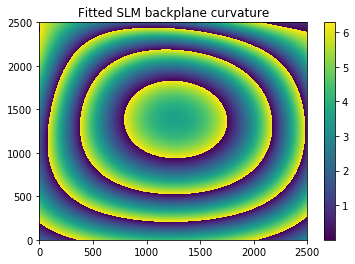

In [64]:
resX= 2500 # SLM x axis resolution - in the paper: 1280
resY= 2500 # SLM y axis resolution - in the paper: 960

# ---------------- SLM 2-PI VOLTAGE MAP ----------------
twopimap = np.zeros((resY,resX))+206

# ---------------- SLM CAVITY (r3) ----------------
##### reflection coefficients #####
r1 = 0 # air - glass, set to not zero (e.g. 0.01) to simulate SLM cavity effect
r3 = 1 # LC - aluminum backplane (always supposed 1)

# ---------------- SLM CURVATURE (phi2) ----------------
twopimap = np.zeros((resY,resX))+206
# Load curvature (cropped curvature, SLM central area)
curv_filepath = 'extrapolated_curv.txt'
curvature_cropped = 2*np.pi - np.loadtxt(curv_filepath)*2*np.pi

# Interpolate the cropped curvature to retrieve curvature for whole SLM screen
x = np.linspace(0, 1, np.shape(curvature_cropped)[1])
y = np.linspace(0, 1, np.shape(curvature_cropped)[0])
x_new = np.linspace(0, 1, resX)
y_new = np.linspace(0, 1, resY)

f = interpolate.interp2d(x,y, curvature_cropped, kind='cubic')
curvature_whole_screen = f(x_new, y_new)
phi2 = np.mod( np.copy(curvature_whole_screen), 2*np.pi)

plt.pcolormesh(phi2)
plt.colorbar()
plt.title('Fitted SLM backplane curvature')
plt.show()

half_x, half_y = np.int(np.ceil(resX/2)), np.int(np.ceil(resY/2))
X_array, Y_array = np.arange(-half_x,half_x,1), np.arange(-half_y,half_y,1)
X, Y = np.meshgrid(X_array, Y_array)
Y = np.flip(Y,axis=0)

###  Populate M, F lookup tables: minimized_M, minimized_F
#### minimized_M, minimized_F need to be calculated for each value of r3 
#### note: this cell takes up to 10 minutes to run on a 2.4 GHz Intel Core 2 Duo, 8GB RAM
#### it's better to calculate them once and then load them

In [ ]:
# -----------------------------------------------------------------------------------------
minimized_M = np.zeros((256,2,phi2_precision))
minimized_F = np.zeros((256,2,phi2_precision))

axis = np.linspace(0,2*np.pi,axis_size, endpoint=False) 
# ! endpoint=False so integral(exp(j*axis)) = 0
eaxis = np.exp((1j)*(-ORDER*axis))

M = np.linspace(0, 1, precision)
F = 2*np.pi*np.linspace(0, 1, precision)/ORDER

phi2_axis = 2*np.pi*np.arange(0, phi2_precision, 1)/phi2_precision
ephi2_axis = np.exp((1j)*phi2_axis)

def integral(M, F, phi2_val):
    """ Calculates integral of Eq.8 for a pair of (M, F, )"""
    epattern = r3*np.exp((1j)*(M*np.mod(axis+F,2*np.pi)) )*phi2_val
    o1 = eaxis*(epattern)/( 1+epattern*r1 )
    o = np.sum(o1)/axis_size
    return o

for index_phi2,value_phi2 in enumerate(ephi2_axis):
    func_samples = np.array([[integral(M[i],F[j],value_phi2) for j in range(F.size)] for i in range(M.size)],dtype='complex')
    for abs_value in range(256): # loop over 255 gray levels
        for angle_value in range(2): # loop over HG modes phases value, 0 or 1 (*pi)
            test_mode = (abs_value/256) * np.exp((1j) * np.pi * angle_value)
            xx = (np.abs(func_samples-test_mode)).argmin()
            xx = np.unravel_index(xx, func_samples.shape)
            minimized_M[abs_value,angle_value,index_phi2] = M[xx[0]]
            minimized_F[abs_value,angle_value,index_phi2] = F[xx[1]]

In [4]:
#M_lookup_r0 = torch.save(torch.from_numpy(minimized_M), 'M_lookup_r0.pt')
#F_lookup_r0 = torch.save(torch.from_numpy(minimized_F), 'F_lookup_r0.pt')
minimized_M, minimized_F = torch.load('M_lookup_r0.pt'), torch.load('F_lookup_r0.pt')

####  Mode to produce in the far field, after selecting first diffraction order, as shown in Fig.2

(2500, 2500) (2500, 2500) (2500, 2500)
(2500, 2500) (2500, 2500) (2500, 2500)


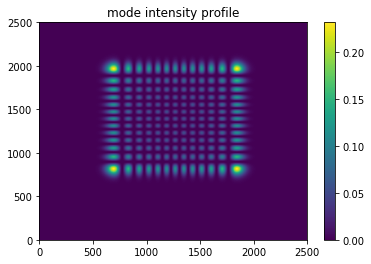

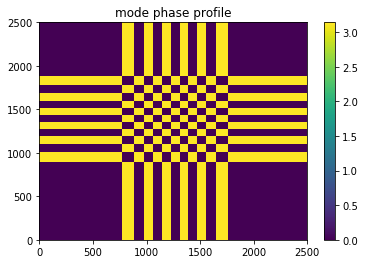

In [5]:
## HG mode that we want to produce
w = 180
z = 1e-17
H = HgBasis( 780e-9, w, w ) 
mode = H.generate_hg(12, 12, X, Y, z) 
mode = shiftXY(mode, half_x+np.where(curvature_whole_screen == np.min(curvature_whole_screen))[1][0], half_y+np.where(curvature_whole_screen == np.min(curvature_whole_screen))[0][0])

plt.pcolormesh(np.abs(mode)**2)
plt.title('mode intensity profile')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(mode))
plt.title('mode phase profile')
plt.colorbar()
plt.show()

####  calculate SLM compensation hologram (takes up to 5 mins)

In [7]:
period = 10 # SLM grating period 
pattern, M_mode, F_mode = cavity(mode, period)

In [ ]:
## plt.pcolormesh(pattern) 
## plt.title('SLM phase profile')
## plt.colorbar()
## plt.show()

### SLM near field (sum of all diffraction orders)

In [8]:
near_field = (r1+np.exp(1j*(pattern + phi2)))/(1+r1*np.exp(1j*(pattern + phi2)))
#plt.pcolormesh(np.angle(near_field))
#plt.title('Beam phase profile at SLM near field')
#plt.colorbar()
#plt.show()

In [9]:
# we pad near field before calculating Fourier Transform
# to increase fft resolution, use k>1 
k=1
near_field_padded = np.pad(near_field, k*near_field.shape, mode='constant')
far_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(near_field_padded)))   

(7500, 7500)

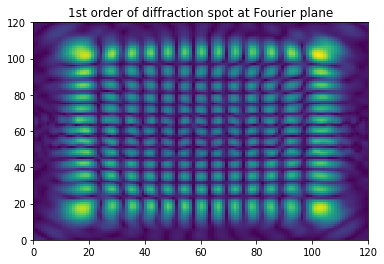

In [31]:
res_x_ff, res_y_ff = int( far_field.shape[0]/2 ), int( far_field.shape[1]/2 )
half_window = 60
pos_y_1st_order = 4500

far_field_selected = far_field[res_x_ff-half_window:res_x_ff+half_window, pos_y_1st_order-half_window:pos_y_1st_order+half_window]
plt.pcolormesh(np.abs(far_field_selected))
plt.title('1st order of diffraction spot at Fourier plane')
near_field_padded.shape

In [32]:
far_field_padded = np.pad(far_field_selected, far_field_selected.shape, mode='constant')
near_first_order = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(far_field_padded)))

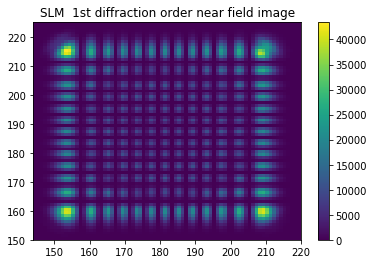

In [63]:
plt.pcolormesh(np.abs(near_first_order)**2)
plt.title('SLM  1st diffraction order near field image')
plt.colorbar()
plt.xlim(144,220)
plt.ylim(150,225)
plt.show()